In [9]:
import os, random, numpy as np, torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm

def set_seed(s=42):
    random.seed(s); np.random.seed(s); torch.manual_seed(s)

def get_device():
    if torch.backends.mps.is_available():
        return torch.device("mps")  # Apple GPU
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [10]:
def build_loaders(train_dir, val_dir, img_size=224, batch_size=32):
    tf_train = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
    ])
    tf_val = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
    ])
    ds_tr = datasets.ImageFolder(train_dir, transform=tf_train)
    ds_va = datasets.ImageFolder(val_dir, transform=tf_val)
    dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True,  num_workers=0)
    dl_va = DataLoader(ds_va, batch_size=batch_size, shuffle=False, num_workers=0)
    return dl_tr, dl_va, len(ds_tr.classes),ds_tr.classes

In [11]:
def build_model(num_classes, arch="efficientnet_b0", pretrained=True, dropout=0.2):
    if arch == "efficientnet_b0":
        m = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1 if pretrained else None)
        in_feats = m.classifier[1].in_features
        m.classifier[1] = nn.Identity()
        head = nn.Sequential(nn.Dropout(dropout), nn.Linear(in_feats, num_classes))
        return nn.Sequential(m, head)
    elif arch == "mobilenet_v3_large":
        m = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V2 if pretrained else None)
        in_feats = m.classifier[0].in_features if hasattr(m.classifier[0], "in_features") else 960
        m.classifier = nn.Identity()
        head = nn.Sequential(nn.Dropout(dropout), nn.Linear(in_feats, num_classes))
        return nn.Sequential(m, head)
    else:  # resnet50
        m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2 if pretrained else None)
        in_feats = m.fc.in_features
        m.fc = nn.Linear(in_feats, num_classes)
        return m


In [13]:
def evaluate(model, loader, device):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            pred = logits.argmax(1)
            correct += (pred == y).sum().item()
            total += y.numel()
    return 100.0 * correct / total

def train_loop(train_loader, val_loader, model, device, epochs=15, lr=3e-4):
    criterion = nn.CrossEntropyLoss()
    optim = AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optim, T_max=len(train_loader)*epochs)

    best_val = 0.0
    for epoch in range(epochs):
        model.train()
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for xb, yb in pbar:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            optim.zero_grad(set_to_none=True)
            loss.backward()
            optim.step()
            scheduler.step()
            pbar.set_postfix(loss=float(loss.item()))
        val_acc = evaluate(model, val_loader, device)
        print(f"Epoch {epoch+1}: val_acc={val_acc:.2f}%")
        if val_acc > best_val:
            best_val = val_acc
            torch.save(model.state_dict(), "best_model.pt")
    print("Best val acc:", best_val)


In [15]:
set_seed(42)
device = get_device()
print("Using device:", device)

train_dir = "RiceLeafsDisease/train"
val_dir   = "RiceLeafsDisease/validation"

train_loader, val_loader, ncls, class_names = build_loaders(
    train_dir, val_dir, img_size=224, batch_size=32
)
model = build_model(ncls, arch="efficientnet_b0").to(device)

train_loop(train_loader, val_loader, model, device, epochs=15, lr=3e-4)


Using device: mps


Epoch 1/15: 100%|███████████████████| 66/66 [00:41<00:00,  1.60it/s, loss=0.233]


Epoch 1: val_acc=92.42%


Epoch 2/15: 100%|████████████████████| 66/66 [00:40<00:00,  1.61it/s, loss=0.51]


Epoch 2: val_acc=95.08%


Epoch 3/15: 100%|███████████████████| 66/66 [00:41<00:00,  1.61it/s, loss=0.203]


Epoch 3: val_acc=96.59%


Epoch 4/15: 100%|███████████████████| 66/66 [00:41<00:00,  1.61it/s, loss=0.063]


Epoch 4: val_acc=96.40%


Epoch 5/15: 100%|██████████████████| 66/66 [00:41<00:00,  1.60it/s, loss=0.0497]


Epoch 5: val_acc=97.92%


Epoch 6/15: 100%|██████████████████| 66/66 [00:41<00:00,  1.60it/s, loss=0.0977]


Epoch 6: val_acc=97.16%


Epoch 7/15: 100%|██████████████████| 66/66 [00:41<00:00,  1.60it/s, loss=0.0079]


Epoch 7: val_acc=97.92%


Epoch 8/15: 100%|████████████████████| 66/66 [00:41<00:00,  1.60it/s, loss=0.16]


Epoch 8: val_acc=98.48%


Epoch 9/15: 100%|█████████████████| 66/66 [00:41<00:00,  1.60it/s, loss=0.00298]


Epoch 9: val_acc=99.24%


Epoch 10/15: 100%|██████████████████| 66/66 [00:41<00:00,  1.60it/s, loss=0.136]


Epoch 10: val_acc=99.05%


Epoch 11/15: 100%|███████████████| 66/66 [00:41<00:00,  1.60it/s, loss=0.000531]


Epoch 11: val_acc=99.05%


Epoch 12/15: 100%|████████████████| 66/66 [00:41<00:00,  1.60it/s, loss=0.00434]


Epoch 12: val_acc=99.05%


Epoch 13/15: 100%|█████████████████| 66/66 [00:41<00:00,  1.60it/s, loss=0.0051]


Epoch 13: val_acc=99.05%


Epoch 14/15: 100%|█████████████████| 66/66 [00:41<00:00,  1.60it/s, loss=0.0185]


Epoch 14: val_acc=99.24%


Epoch 15/15: 100%|█████████████████| 66/66 [00:41<00:00,  1.60it/s, loss=0.0613]


Epoch 15: val_acc=99.05%
Best val acc: 99.24242424242425


In [16]:
import torch, json, os
os.makedirs("artifacts", exist_ok=True)

torch.save(model.state_dict(), "artifacts/best_model.pt")
# save class names for inference
class_names = datasets.ImageFolder(train_dir).classes
with open("artifacts/classes.json", "w") as f:
    json.dump(class_names, f)
print("Saved:", len(class_names), "classes")


Saved: 6 classes


In [17]:
from sklearn.metrics import classification_report
import numpy as np

y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for xb, yb in val_loader:
        logits = model(xb.to(device))
        y_pred.extend(logits.argmax(1).cpu().numpy())
        y_true.extend(yb.numpy())

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


                       precision    recall  f1-score   support

bacterial_leaf_blight     1.0000    1.0000    1.0000        88
           brown_spot     0.9770    0.9659    0.9714        88
              healthy     0.9778    1.0000    0.9888        88
           leaf_blast     0.9885    0.9773    0.9829        88
           leaf_scald     1.0000    1.0000    1.0000        88
    narrow_brown_spot     1.0000    1.0000    1.0000        88

             accuracy                         0.9905       528
            macro avg     0.9905    0.9905    0.9905       528
         weighted avg     0.9905    0.9905    0.9905       528



In [19]:
import torch
import torch.nn as nn
from torchvision import models, datasets

# 1) class names
train_ds = datasets.ImageFolder(train_dir)
class_names = train_ds.classes
num_classes = len(class_names)

# 2) REBUILD MODEL EXACTLY AS TRAINING (Sequential(backbone, head))
def build_trained_model(num_classes, dropout=0.2):
    backbone = models.efficientnet_b0(weights=None)    # no pretrained when loading
    in_feats = backbone.classifier[1].in_features
    backbone.classifier[1] = nn.Identity()             # remove final FC
    head = nn.Sequential(nn.Dropout(dropout), nn.Linear(in_feats, num_classes))
    return nn.Sequential(backbone, head)

model = build_trained_model(num_classes)

# 3) LOAD WEIGHTS
state = torch.load("artifacts/best_model.pt", map_location="cpu")
model.load_state_dict(state, strict=True)              # should load cleanly now
model.eval()
print("Model and weights reloaded ✅")


Model and weights reloaded ✅


In [22]:
import torch, torch.nn as nn
from torchvision import models, datasets

# device
device = torch.device("mps") if torch.backends.mps.is_available() else (
         torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
print("Device:", device)

# class names
train_ds = datasets.ImageFolder(train_dir)
class_names = train_ds.classes
num_classes = len(class_names)

# rebuild EXACT training structure: Sequential(backbone, head)
def build_trained_model(num_classes, dropout=0.2):
    backbone = models.efficientnet_b0(weights=None)
    in_feats = backbone.classifier[1].in_features
    backbone.classifier[1] = nn.Identity()
    head = nn.Sequential(nn.Dropout(dropout), nn.Linear(in_feats, num_classes))
    return nn.Sequential(backbone, head)

# 1) build
model = build_trained_model(num_classes)

# 2) load weights (loaded on CPU is fine)
state = torch.load("artifacts/best_model.pt", map_location="cpu")
model.load_state_dict(state, strict=True)

# 3) MOVE MODEL TO THE SAME DEVICE AS INPUTS
model = model.to(device).eval()

# 4) collect predictions
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)                    # inputs on same device
        logits = model(xb)                    # no dtype/device mismatch now
        y_pred.extend(logits.argmax(1).cpu().numpy())
        y_true.extend(yb.numpy())

print("Collected predictions for", len(y_true), "validation samples")


Device: mps
Collected predictions for 528 validation samples


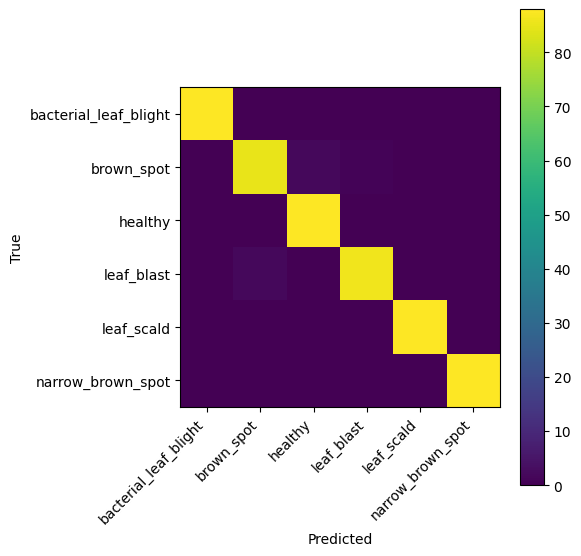

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(cm, interpolation='nearest')
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_xticks(range(len(class_names))); ax.set_xticklabels(class_names, rotation=45, ha="right")
ax.set_yticks(range(len(class_names))) ; ax.set_yticklabels(class_names)
plt.colorbar(im); plt.tight_layout(); plt.show()


In [24]:
import torch
from torchvision import transforms
from PIL import Image

# device (same as before)
device = torch.device("mps") if torch.backends.mps.is_available() else (
         torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))

# define same preprocessing you used in training/validation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],   # ImageNet normalization (used by torchvision models)
        std=[0.229, 0.224, 0.225]
    )
])

# load an image
img_path = "test.png"   # put your test image path here
img = Image.open(img_path).convert("RGB")

# preprocess
x = transform(img).unsqueeze(0).to(device)   # add batch dimension and move to device

# inference
model.eval()
with torch.no_grad():
    logits = model(x)
    pred = logits.argmax(1).item()

# show result
print("Predicted class index:", pred)
print("Predicted class name:", class_names[pred])


Predicted class index: 3
Predicted class name: leaf_blast
